In [1]:
!pip -q install ucimlrepo scikit-learn pandas numpy matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ucimlrepo import fetch_ucirepo

heart = fetch_ucirepo(id=45)   # Heart Disease (Cleveland)

X = heart.data.features
y = heart.data.targets

print("X shape:", X.shape)
print("y shape:", y.shape)
display(X.head())
display(y.head())
print("Target unique values:", sorted(pd.unique(y.iloc[:, 0])))


X shape: (303, 13)
y shape: (303, 1)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0


,num
0,0
1,2
2,1
3,0
4,0


Target unique values: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]


In [2]:
y_raw = pd.to_numeric(y.iloc[:, 0], errors="coerce")
y_bin = (y_raw > 0).astype(int).values

print("Binary target counts (0=no disease, 1=disease):", np.bincount(y_bin))


Binary target counts (0=no disease, 1=disease): [164 139]


In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

X_df = X.copy()

# Detect numeric vs categorical columns
numeric_cols = X_df.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = [c for c in X_df.columns if c not in numeric_cols]

print("Numeric cols:", numeric_cols)
print("Categorical cols:", categorical_cols)

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, categorical_cols)
])


Numeric cols: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
Categorical cols: []


In [4]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score, f1_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "accuracy": make_scorer(accuracy_score),
    "f1": make_scorer(f1_score)
}

def evaluate_model(name, model, X, y):
    res = cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    print(f"\n{name}")
    print(f"  Accuracy: {res['test_accuracy'].mean():.4f} ± {res['test_accuracy'].std():.4f}")
    print(f"  F1-score:  {res['test_f1'].mean():.4f} ± {res['test_f1'].std():.4f}")
    return res

linear_svm = Pipeline([
    ("preprocess", preprocess),
    ("svm", SVC(kernel="linear", C=1.0))
])

rbf_svm = Pipeline([
    ("preprocess", preprocess),
    ("svm", SVC(kernel="rbf", C=1.0, gamma="scale"))
])

poly_svm = Pipeline([
    ("preprocess", preprocess),
    ("svm", SVC(kernel="poly", degree=3, C=1.0, gamma="scale", coef0=1))
])

res_linear = evaluate_model("SVM (Linear)", linear_svm, X_df, y_bin)
res_rbf    = evaluate_model("SVM (RBF)", rbf_svm, X_df, y_bin)
res_poly   = evaluate_model("SVM (Poly deg=3)", poly_svm, X_df, y_bin)



SVM (Linear)
  Accuracy: 0.8349 ± 0.0408
  F1-score:  0.8153 ± 0.0464

SVM (RBF)
  Accuracy: 0.8381 ± 0.0390
  F1-score:  0.8153 ± 0.0467

SVM (Poly deg=3)
  Accuracy: 0.8084 ± 0.0446
  F1-score:  0.7885 ± 0.0458


In [5]:
from sklearn.metrics.pairwise import linear_kernel, rbf_kernel

def hybrid_kernel_matrix(X1, X2, alpha=0.5, gamma="scale"):
    K_lin = linear_kernel(X1, X2)
    if gamma == "scale":
        g = 1.0 / (X1.shape[1] * np.var(X1))
    else:
        g = float(gamma)
    K_rbf = rbf_kernel(X1, X2, gamma=g)
    return alpha * K_lin + (1 - alpha) * K_rbf

def evaluate_hybrid(alpha=0.5, C=1.0):
    accs, f1s = [], []

    # Fit preprocess on full X, then use it inside CV folds correctly:
    # We must fit preprocessing only on train fold each time to avoid leakage.
    for train_idx, test_idx in cv.split(X_df, y_bin):
        X_train_raw = X_df.iloc[train_idx]
        X_test_raw  = X_df.iloc[test_idx]
        y_train = y_bin[train_idx]
        y_test  = y_bin[test_idx]

        # Fit preprocess on training fold only
        X_train = preprocess.fit_transform(X_train_raw)
        X_test  = preprocess.transform(X_test_raw)

        K_train = hybrid_kernel_matrix(X_train, X_train, alpha=alpha, gamma="scale")
        K_test  = hybrid_kernel_matrix(X_test, X_train, alpha=alpha, gamma="scale")

        clf = SVC(kernel="precomputed", C=C)
        clf.fit(K_train, y_train)
        y_pred = clf.predict(K_test)

        accs.append(accuracy_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred))

    print(f"\nHybrid SVM (alpha={alpha})")
    print(f"  Accuracy: {np.mean(accs):.4f} ± {np.std(accs):.4f}")
    print(f"  F1-score:  {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")

# Try a sweep like you did before
for a in [0.0, 0.25, 0.5, 0.75, 1.0]:
    evaluate_hybrid(alpha=a, C=1.0)



Hybrid SVM (alpha=0.0)
  Accuracy: 0.8381 ± 0.0390
  F1-score:  0.8153 ± 0.0467

Hybrid SVM (alpha=0.25)
  Accuracy: 0.8381 ± 0.0388
  F1-score:  0.8190 ± 0.0422

Hybrid SVM (alpha=0.5)
  Accuracy: 0.8414 ± 0.0378
  F1-score:  0.8227 ± 0.0426

Hybrid SVM (alpha=0.75)
  Accuracy: 0.8349 ± 0.0336
  F1-score:  0.8152 ± 0.0390

Hybrid SVM (alpha=1.0)
  Accuracy: 0.8349 ± 0.0408
  F1-score:  0.8153 ± 0.0464


In [7]:
from sklearn.model_selection import cross_val_predict

def oof_standard(model, X, y):
    y_pred = cross_val_predict(model, X, y, cv=cv, method="predict")
    y_score = cross_val_predict(model, X, y, cv=cv, method="decision_function")
    return y_pred, y_score

y_pred_lin,  y_score_lin  = oof_standard(linear_svm, X_df, y_bin)
y_pred_rbf,  y_score_rbf  = oof_standard(rbf_svm, X_df, y_bin)
y_pred_poly, y_score_poly = oof_standard(poly_svm, X_df, y_bin)

BEST_ALPHA = 0.5

def oof_hybrid(alpha=0.5, C=1.0):
    y_pred = np.zeros_like(y_bin)
    y_score = np.zeros_like(y_bin, dtype=float)

    for train_idx, test_idx in cv.split(X_df, y_bin):
        X_train_raw = X_df.iloc[train_idx]
        X_test_raw  = X_df.iloc[test_idx]
        y_train = y_bin[train_idx]

        X_train = preprocess.fit_transform(X_train_raw)
        X_test  = preprocess.transform(X_test_raw)

        K_train = hybrid_kernel_matrix(X_train, X_train, alpha=alpha, gamma="scale")
        K_test  = hybrid_kernel_matrix(X_test, X_train, alpha=alpha, gamma="scale")

        clf = SVC(kernel="precomputed", C=C)
        clf.fit(K_train, y_train)

        y_pred[test_idx] = clf.predict(K_test)
        y_score[test_idx] = clf.decision_function(K_test)

    return y_pred, y_score

y_pred_hyb, y_score_hyb = oof_hybrid(alpha=BEST_ALPHA, C=1.0)

models = {
    "Linear": (y_pred_lin, y_score_lin),
    "RBF": (y_pred_rbf, y_score_rbf),
    "Poly (deg=3)": (y_pred_poly, y_score_poly),
    f"Hybrid (α={BEST_ALPHA})": (y_pred_hyb, y_score_hyb),
}


,Model,Accuracy,F1
3,Hybrid (α=0.5),0.841584,0.823529
1,RBF,0.838284,0.816479
0,Linear,0.834983,0.816176
2,Poly (deg=3),0.808581,0.788321


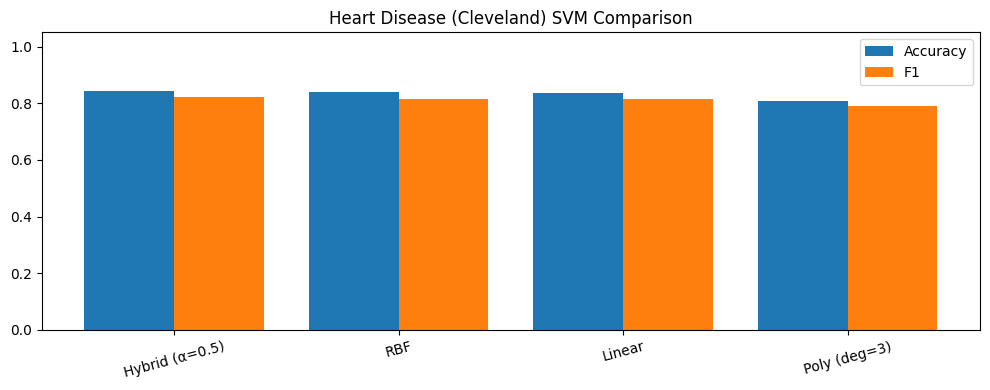

<Figure size 400x400 with 0 Axes>

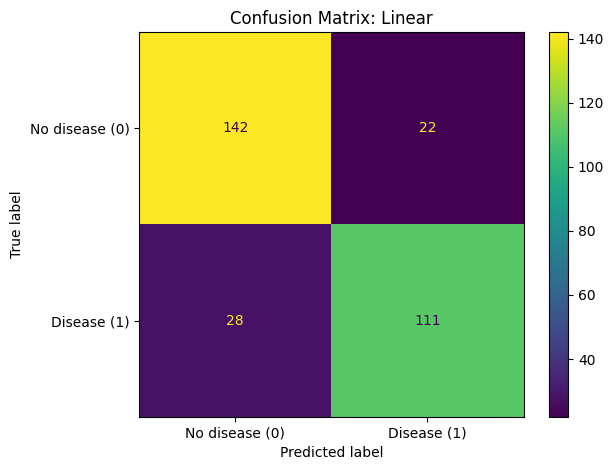

<Figure size 400x400 with 0 Axes>

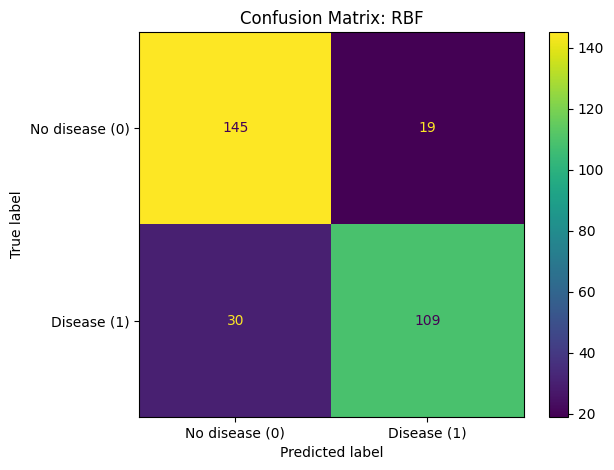

<Figure size 400x400 with 0 Axes>

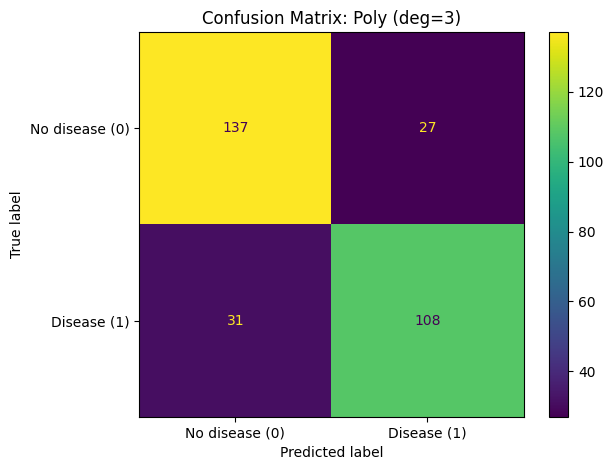

<Figure size 400x400 with 0 Axes>

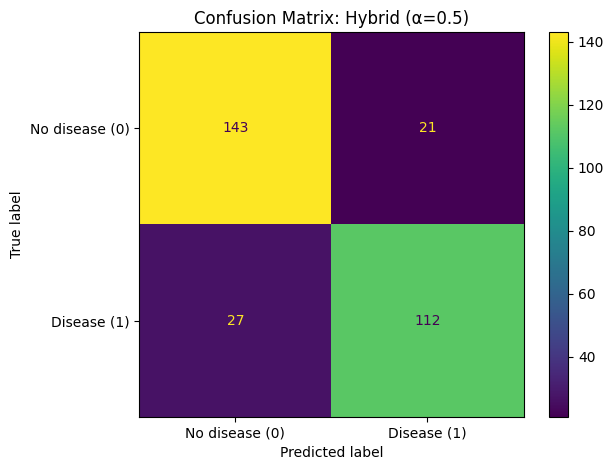

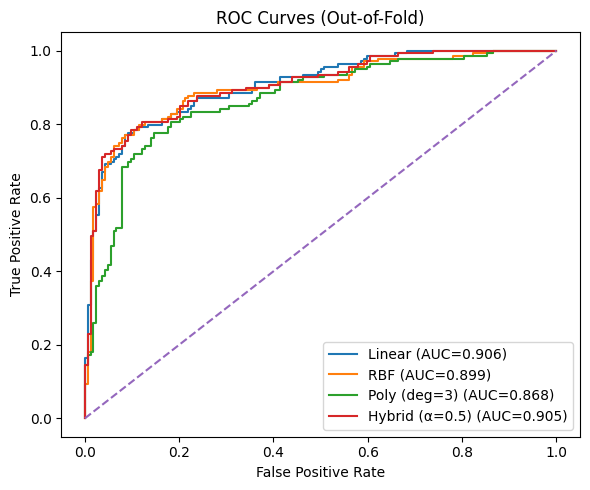

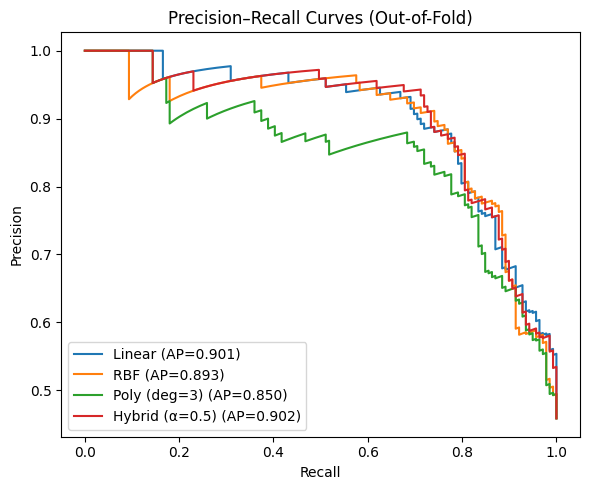

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Metrics table
rows = []
for name, (yp, ys) in models.items():
    rows.append({
        "Model": name,
        "Accuracy": accuracy_score(y_bin, yp),
        "F1": f1_score(y_bin, yp)
    })
df_metrics = pd.DataFrame(rows).sort_values("F1", ascending=False)
display(df_metrics)

# Bar plot
plt.figure(figsize=(10, 4))
x = np.arange(len(df_metrics))
plt.bar(x - 0.2, df_metrics["Accuracy"], width=0.4, label="Accuracy")
plt.bar(x + 0.2, df_metrics["F1"], width=0.4, label="F1")
plt.xticks(x, df_metrics["Model"], rotation=15)
plt.ylim(0, 1.05)
plt.title("Heart Disease (Cleveland) SVM Comparison")
plt.legend()
plt.tight_layout()
plt.show()

# Confusion matrices
for name, (yp, _) in models.items():
    cm = confusion_matrix(y_bin, yp)
    disp = ConfusionMatrixDisplay(cm, display_labels=["No disease (0)", "Disease (1)"])
    plt.figure(figsize=(4, 4))
    disp.plot(values_format="d")
    plt.title(f"Confusion Matrix: {name}")
    plt.tight_layout()
    plt.show()

# ROC curves
plt.figure(figsize=(6, 5))
for name, (_, ys) in models.items():
    fpr, tpr, _ = roc_curve(y_bin, ys)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr, tpr):.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Out-of-Fold)")
plt.legend()
plt.tight_layout()
plt.show()

# Precision-Recall curves
plt.figure(figsize=(6, 5))
for name, (_, ys) in models.items():
    prec, rec, _ = precision_recall_curve(y_bin, ys)
    ap = average_precision_score(y_bin, ys)
    plt.plot(rec, prec, label=f"{name} (AP={ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves (Out-of-Fold)")
plt.legend()
plt.tight_layout()
plt.show()


Intercept b: -0.1523573180004774


,feature,weight,abs_weight
11,ca,0.691711,0.691711
12,thal,0.579023,0.579023
2,cp,0.452578,0.452578
7,thalach,-0.366912,0.366912
1,sex,0.328521,0.328521
8,exang,0.231617,0.231617
3,trestbps,0.228042,0.228042
10,slope,0.188868,0.188868
5,fbs,-0.181073,0.181073
4,chol,0.161069,0.161069


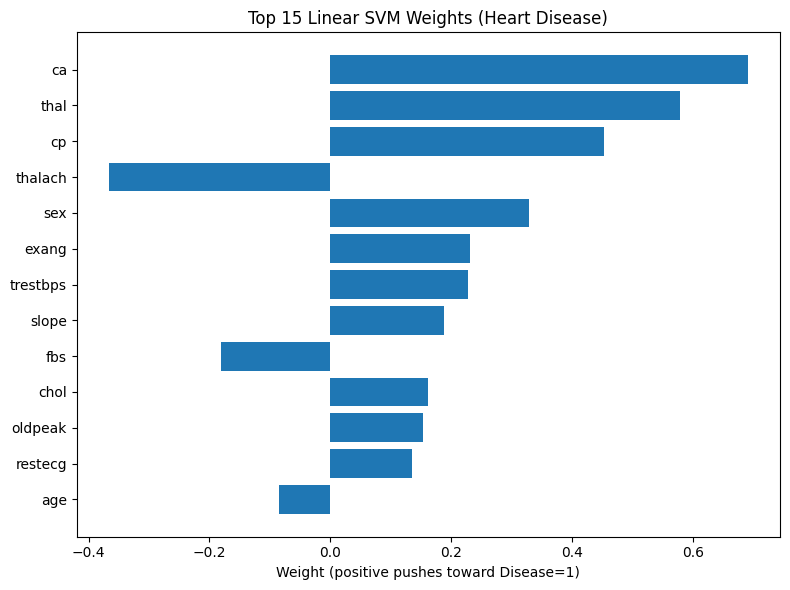

In [9]:
# Fit linear model on full data
linear_fit = linear_svm.fit(X_df, y_bin)

# Get expanded feature names from ColumnTransformer
ohe = linear_fit.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(categorical_cols) if len(categorical_cols) else np.array([])

all_feature_names = np.concatenate([np.array(numeric_cols), cat_feature_names])

w = linear_fit.named_steps["svm"].coef_.ravel()
b = linear_fit.named_steps["svm"].intercept_[0]

df_w = pd.DataFrame({
    "feature": all_feature_names,
    "weight": w,
    "abs_weight": np.abs(w)
}).sort_values("abs_weight", ascending=False)

print("Intercept b:", b)
display(df_w.head(20))

topk = 15
df_top = df_w.head(topk).iloc[::-1]
plt.figure(figsize=(8, 6))
plt.barh(df_top["feature"], df_top["weight"])
plt.title(f"Top {topk} Linear SVM Weights (Heart Disease)")
plt.xlabel("Weight (positive pushes toward Disease=1)")
plt.tight_layout()
plt.show()



Permutation Importance (F1): Linear SVM


,feature,importance_mean,importance_std
11,ca,0.059389,0.014463
12,thal,0.053862,0.013940
2,cp,0.022296,0.013934
1,sex,0.016291,0.008226
7,thalach,0.002647,0.009134
5,fbs,0.000196,0.005087
3,trestbps,-0.002124,0.006614
0,age,-0.003677,0.002297
9,oldpeak,-0.004672,0.005588
8,exang,-0.006155,0.006998


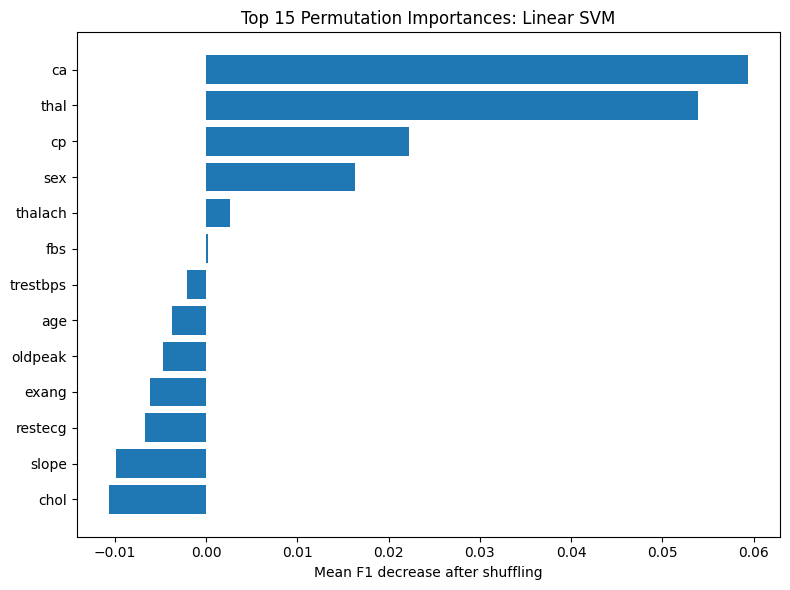


Permutation Importance (F1): RBF SVM


,feature,importance_mean,importance_std
11,ca,0.051429,0.016583
12,thal,0.051002,0.008282
2,cp,0.044338,0.011428
3,trestbps,0.020467,0.007426
9,oldpeak,0.016288,0.009587
1,sex,0.016204,0.007873
0,age,0.014328,0.005946
6,restecg,0.012497,0.006244
7,thalach,0.010988,0.013317
5,fbs,0.010700,0.005531


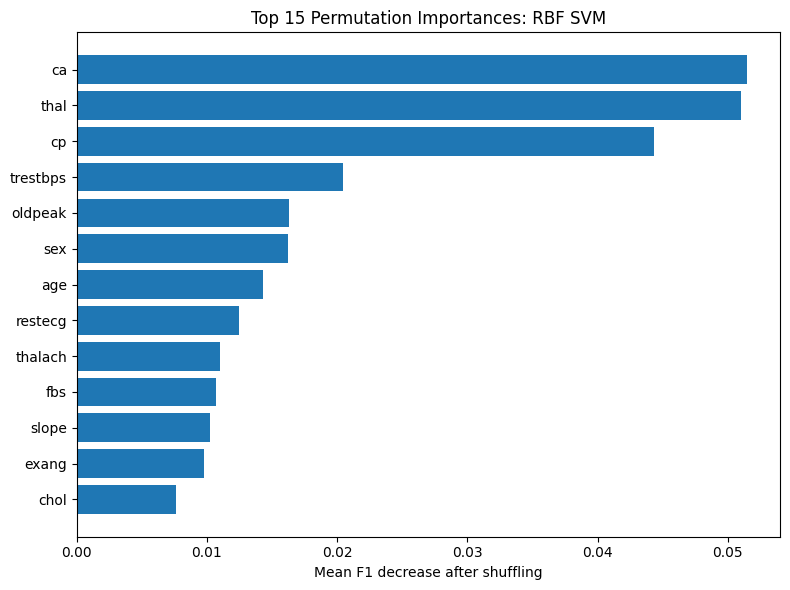


Permutation Importance (F1): Poly SVM


,feature,importance_mean,importance_std
11,ca,0.115719,0.013586
12,thal,0.104530,0.012017
2,cp,0.084226,0.014768
10,slope,0.046736,0.006576
8,exang,0.040691,0.009949
0,age,0.040520,0.009177
9,oldpeak,0.038709,0.007383
1,sex,0.037211,0.006110
5,fbs,0.034458,0.005375
4,chol,0.029534,0.006198


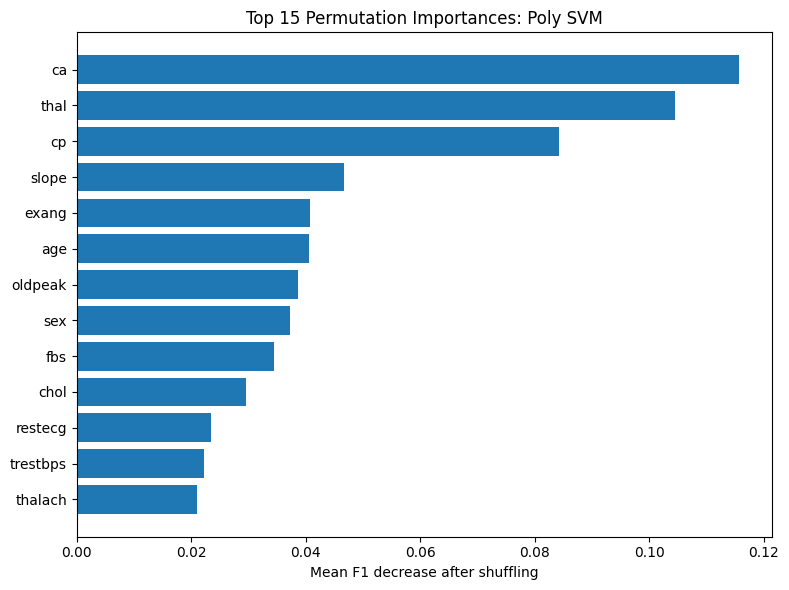

In [10]:
from sklearn.inspection import permutation_importance

def perm_importance(model, X, y, name, n_repeats=15):
    r = permutation_importance(
        model, X, y,
        scoring=make_scorer(f1_score),
        n_repeats=n_repeats,
        random_state=42,
        n_jobs=-1
    )
    imp = pd.DataFrame({
        "feature": X.columns,
        "importance_mean": r.importances_mean,
        "importance_std": r.importances_std
    }).sort_values("importance_mean", ascending=False)

    print(f"\nPermutation Importance (F1): {name}")
    display(imp.head(15))

    dfp = imp.head(15).iloc[::-1]
    plt.figure(figsize=(8, 6))
    plt.barh(dfp["feature"], dfp["importance_mean"])
    plt.title(f"Top 15 Permutation Importances: {name}")
    plt.xlabel("Mean F1 decrease after shuffling")
    plt.tight_layout()
    plt.show()

perm_importance(linear_fit, X_df, y_bin, "Linear SVM")
perm_importance(rbf_svm.fit(X_df, y_bin), X_df, y_bin, "RBF SVM")
perm_importance(poly_svm.fit(X_df, y_bin), X_df, y_bin, "Poly SVM")


Best model: Hybrid (α=0.5)
Example Disease=1 index: 1
Example Disease=0 index: 0
Sample: 1 True: 1 Pred: 1 Score: 3.4575362791318187


,feature,impact_on_score,abs_impact
11,ca,2.224549,2.224549
3,trestbps,2.076569,2.076569
2,cp,1.888614,1.888614
7,thalach,-1.735172,1.735172
12,thal,0.897627,0.897627
4,chol,0.891168,0.891168
1,sex,0.704184,0.704184
0,age,-0.630904,0.630904
10,slope,0.613995,0.613995
8,exang,0.493833,0.493833


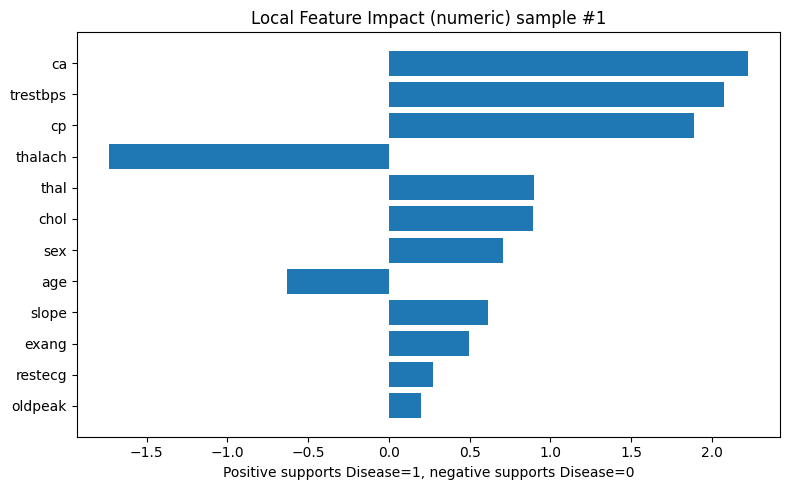

Sample: 0 True: 0 Pred: 0 Score: -0.8726431792781582


,feature,impact_on_score,abs_impact
7,thalach,-2.409961,2.409961
3,trestbps,1.881891,1.881891
12,thal,1.795253,1.795253
10,slope,0.920993,0.920993
4,chol,0.726022,0.726022
1,sex,0.704184,0.704184
0,age,-0.593238,0.593238
5,fbs,-0.509192,0.509192
2,cp,0.472153,0.472153
9,oldpeak,0.305265,0.305265


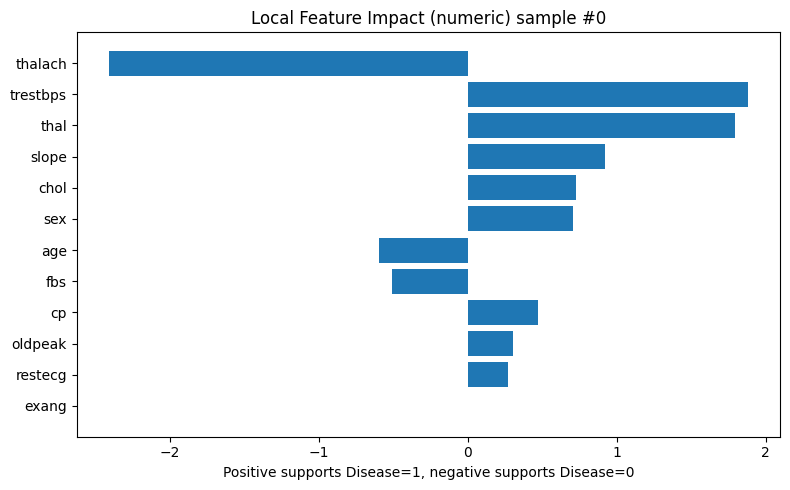

In [11]:
def local_feature_impact(pipeline_model, X_df, y, sample_index=0, topk=12):
    preprocess_f = pipeline_model.named_steps["preprocess"]
    svm = pipeline_model.named_steps["svm"]

    x = X_df.iloc[[sample_index]]
    x_tr = preprocess_f.transform(x)

    base_score = svm.decision_function(x_tr)[0]
    base_pred = int(base_score >= 0)

    # Only do local impact on numeric features directly (report-friendly and simple)
    # For categorical, this gets messy because one-hot expands them.
    deltas = []
    for fname in numeric_cols:
        x_mod = x.copy()
        x_mod[fname] = 0  # crude perturbation for local sensitivity
        x_mod_tr = preprocess_f.transform(x_mod)
        score_mod = svm.decision_function(x_mod_tr)[0]
        deltas.append((fname, base_score - score_mod))

    df_local = pd.DataFrame(deltas, columns=["feature", "impact_on_score"])
    df_local["abs_impact"] = np.abs(df_local["impact_on_score"])
    df_local = df_local.sort_values("abs_impact", ascending=False)

    print("Sample:", sample_index, "True:", y[sample_index], "Pred:", base_pred, "Score:", base_score)
    display(df_local.head(topk))

    dft = df_local.head(topk).iloc[::-1]
    plt.figure(figsize=(8, 5))
    plt.barh(dft["feature"], dft["impact_on_score"])
    plt.title(f"Local Feature Impact (numeric) sample #{sample_index}")
    plt.xlabel("Positive supports Disease=1, negative supports Disease=0")
    plt.tight_layout()
    plt.show()

# Pick 1 correctly predicted positive and negative using best model by F1
best_name = df_metrics.iloc[0]["Model"]
best_pred, _ = models[best_name]

pos_idx = np.where((y_bin == 1) & (best_pred == 1))[0]
neg_idx = np.where((y_bin == 0) & (best_pred == 0))[0]

idx_pos = int(pos_idx[0]) if len(pos_idx) else 0
idx_neg = int(neg_idx[0]) if len(neg_idx) else 0

print("Best model:", best_name)
print("Example Disease=1 index:", idx_pos)
print("Example Disease=0 index:", idx_neg)

local_feature_impact(linear_fit, X_df, y_bin, idx_pos)
local_feature_impact(linear_fit, X_df, y_bin, idx_neg)


In [12]:
def support_vector_stats(pipeline_model, name):
    svm = pipeline_model.named_steps["svm"]
    n_sv = svm.n_support_
    total_sv = n_sv.sum()
    print(f"\n{name}")
    print("Support vectors per class [0,1]:", n_sv)
    print("Total SV:", total_sv)
    print("SV fraction:", total_sv / len(X_df))

support_vector_stats(linear_fit, "Linear SVM")
support_vector_stats(rbf_svm.fit(X_df, y_bin), "RBF SVM")
support_vector_stats(poly_svm.fit(X_df, y_bin), "Poly SVM")



Linear SVM
Support vectors per class [0,1]: [57 59]
Total SV: 116
SV fraction: 0.38283828382838286

RBF SVM
Support vectors per class [0,1]: [85 82]
Total SV: 167
SV fraction: 0.5511551155115512

Poly SVM
Support vectors per class [0,1]: [67 64]
Total SV: 131
SV fraction: 0.43234323432343236



Surrogate explanation: RBF SVM
Surrogate accuracy vs SVM decisions: 0.9603960396039604


,feature,coef,abs_coef
12,thal,2.042905,2.042905
11,ca,2.008791,2.008791
2,cp,1.809399,1.809399
8,exang,1.376285,1.376285
9,oldpeak,0.957357,0.957357
1,sex,0.872636,0.872636
7,thalach,-0.715517,0.715517
3,trestbps,0.517355,0.517355
10,slope,0.469029,0.469029
4,chol,0.278539,0.278539


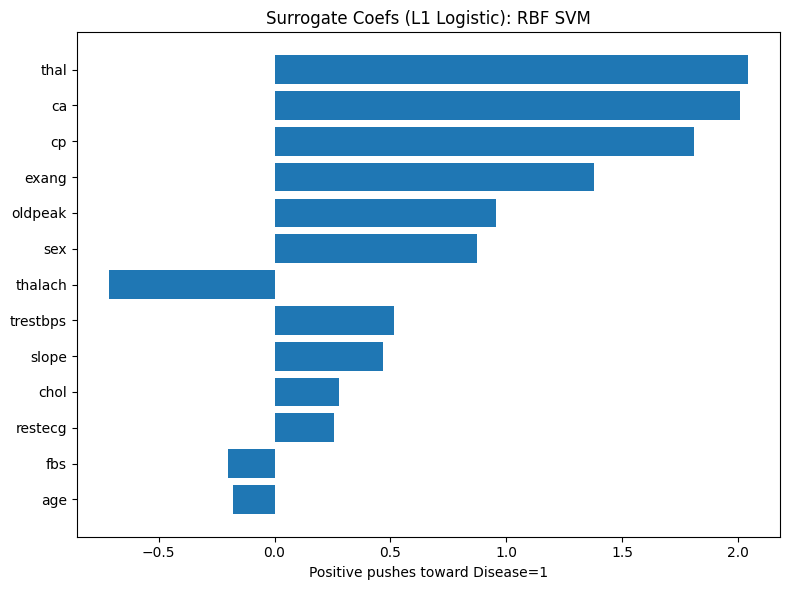


Surrogate explanation: Hybrid SVM (α=0.5)
Surrogate accuracy vs SVM decisions: 0.9933993399339934


,feature,coef,abs_coef
11,ca,2.830884,2.830884
12,thal,2.342556,2.342556
2,cp,1.761011,1.761011
1,sex,1.759115,1.759115
8,exang,1.677946,1.677946
7,thalach,-1.491796,1.491796
6,restecg,1.157056,1.157056
4,chol,0.813076,0.813076
9,oldpeak,0.469841,0.469841
10,slope,0.452381,0.452381


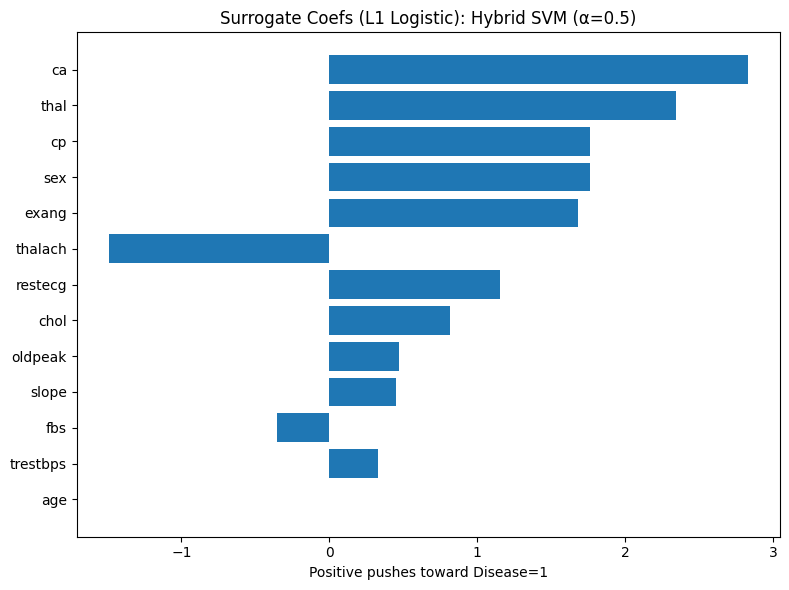

In [14]:
from sklearn.linear_model import LogisticRegression

def surrogate_explain(X_df, svm_scores, title, topk=15):
    # Use numeric only for simplicity and clearer medical meaning
    X_num = X_df[numeric_cols].copy()

    # Use the predefined preprocess pipeline to handle imputation and scaling
    # This ensures consistency with how the SVM models were trained and handles NaNs.
    X_scaled = preprocess.fit_transform(X_num)
    y_sur = (svm_scores >= 0).astype(int)

    sur = LogisticRegression(penalty="l1", solver="liblinear", C=1.0, max_iter=2000)
    sur.fit(X_scaled, y_sur)

    coefs = sur.coef_.ravel()
    df_s = pd.DataFrame({
        "feature": numeric_cols,
        "coef": coefs,
        "abs_coef": np.abs(coefs)
    }).sort_values("abs_coef", ascending=False)

    print("\nSurrogate explanation:", title)
    print("Surrogate accuracy vs SVM decisions:", sur.score(X_scaled, y_sur))
    display(df_s.head(topk))

    dfp = df_s.head(topk).iloc[::-1]
    plt.figure(figsize=(8, 6))
    plt.barh(dfp["feature"], dfp["coef"])
    plt.title(f"Surrogate Coefs (L1 Logistic): {title}")
    plt.xlabel("Positive pushes toward Disease=1")
    plt.tight_layout()
    plt.show()

surrogate_explain(X_df, y_score_rbf, "RBF SVM")
surrogate_explain(X_df, y_score_hyb, f"Hybrid SVM (α={BEST_ALPHA})")


In [15]:
best = df_metrics.iloc[0]
best_model = best["Model"]
best_acc = best["Accuracy"]
best_f1 = best["F1"]

print("Conclusion\n")

print(
f"""We evaluated Support Vector Machine (SVM) classifiers on the Cleveland Heart Disease dataset using 5-fold stratified cross validation.
The task was binary classification of heart disease presence (0 = no disease, 1 = disease), where the original UCI target values (0–4) were converted to a binary label.

Among the tested kernels (Linear, RBF, Polynomial, and Hybrid), the best-performing model was {best_model}, achieving Accuracy = {best_acc:.3f} and F1-score = {best_f1:.3f}.
This indicates that the decision boundary in the clinical feature space is not purely linear and benefits from nonlinear modeling.

For interpretability, the Linear SVM provides direct feature-level explanations through its weight vector, where positive weights increase the likelihood of predicting disease and negative weights support the no-disease class.
For nonlinear kernels (RBF and Hybrid), we used model-agnostic interpretability techniques including permutation feature importance and surrogate modeling to identify the most influential clinical measurements.

Overall, nonlinear SVM kernels improved predictive performance on the Cleveland dataset, while interpretability was preserved through complementary explanation methods.
"""
)


Conclusion (copy into report)

We evaluated Support Vector Machine (SVM) classifiers on the Cleveland Heart Disease dataset using 5-fold stratified cross validation.
The task was binary classification of heart disease presence (0 = no disease, 1 = disease), where the original UCI target values (0–4) were converted to a binary label.

Among the tested kernels (Linear, RBF, Polynomial, and Hybrid), the best-performing model was Hybrid (α=0.5), achieving Accuracy = 0.842 and F1-score = 0.824.
This indicates that the decision boundary in the clinical feature space is not purely linear and benefits from nonlinear modeling.

For interpretability, the Linear SVM provides direct feature-level explanations through its weight vector, where positive weights increase the likelihood of predicting disease and negative weights support the no-disease class.
For nonlinear kernels (RBF and Hybrid), we used model-agnostic interpretability techniques including permutation feature importance and surrogate 